In [4]:
import torch
import deepwave
import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import SoftDTWLossPyTorch
import torch.nn.functional as F
import scipy.signal
import torch.nn as nn

C:\Anaconda3\envs\FWI\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def normalized_shot_gather(csg):
    max_amp = torch.max(torch.abs(csg), dim=-1, keepdim=True)[0]
    normalized_csg = csg / (max_amp + 1e-10)
    return normalized_csg

In [7]:
offset = 5
spacing = 2
n_gp = 24
geophone = np.arange(0, spacing * n_gp, spacing)
x_m = 2 * (n_gp - 1)
z_m = 20
dx = 0.2
n_pml = 10  # buffer to avoid pml's effect

nx = int((x_m + 2 * offset) / dx) + 2 * n_pml
nz = int(z_m / dx)
shot1 = n_pml
shot2 = n_pml + (x_m + 2 * offset) / dx
shot3 = (nx + 2 * n_pml) / 2

receiver = torch.arange(shot1 + offset / dx, shot2 - offset / dx + 1, spacing / dx)
receivers = torch.tensor(receiver, dtype = torch.float32, device = device)
shot_z = 2
receivers_z = 0

C:\Users\Dong Woo\AppData\Local\Temp\ipykernel_13400\3094252379.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  receivers = torch.tensor(receiver, dtype = torch.float32, device = device)


In [8]:
shots = [float(shot1), float(shot2)]
shots_tensor = torch.tensor(shots, dtype=torch.float32, device=device)

In [9]:
fs = 500
dt = 1/fs
t = 0.8
nt = int(t/dt)
time = np.arange(0, dt * nt, dt)
boundary = 6 #m

In [10]:
vp, vs, rho = torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device)

In [11]:
vp[:int(boundary/dx),: ] = 500
vp[int(boundary/dx):, :] = 1000

vs[:int(boundary/dx), :] = 200
vs[int(boundary/dx):, :] = 400

rho[:,:] = 2000

In [12]:
n_shots = len(shots_tensor)
n_sources_per_shot = 1

f0 = 25
peak_time = 1.5 / f0

# source_amplitudes
source_amplitudes = (
    (deepwave.wavelets.ricker(f0, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

shot = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
shot[..., 0] = 2
shot[..., 1] = (shots_tensor).unsqueeze(1)

In [13]:
receiver_locations = torch.zeros(n_shots, len(receivers), 2, dtype=torch.long, device=device)
receiver_locations[..., 0] = 0
receiver_locations[:, :, 1] = receivers

In [14]:
out = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp, vs, rho),
            grid_spacing=dx, dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=shot,
            receiver_locations_y=receiver_locations,
            pml_freq=f0, pml_width=[0,10,10,10]
        )[-2]

In [15]:
out_norm = normalized_shot_gather(out)

In [16]:
v1_list = np.arange(200 - 100, 200 + 100, 5)
v2_list = np.arange(400- 100, 400 + 100, 5)

In [17]:
error_map_c = np.zeros((len(v1_list), len(v2_list)))
error_map_m = np.zeros((len(v1_list), len(v2_list)))
error_map_e = np.zeros((len(v1_list), len(v2_list)))

In [18]:
vs_error = torch.zeros_like(vs)

In [19]:
class EnvelopeLoss(nn.Module):
    """
    관측 파형과 모델링 파형의 Envelope 차이를 계산하는 PyTorch Loss 클래스입니다.
    E(t) = (u(t)^2 + H[u(t)]^2)^(p/2)
    Loss = MSE(E_obs, E_syn)
    """
    def __init__(self, p: float = 1.0):
        """
        Args:
            p (float): Envelope 계산 시 적용할 지수 (기본값: 1.0)
        """
        super().__init__()
        if p <= 0:
            raise ValueError("지수 'p'는 양수여야 합니다.")
        self.p = p
        self.mse_loss = nn.MSELoss()

    def _calculate_envelope(self, signal: torch.Tensor) -> torch.Tensor:
        """Helper-function to compute the envelope of a signal tensor."""
        if signal.dim() != 3:
            raise ValueError("입력 신호는 3차원 텐서(n_shot, n_rec, n_t)여야 합니다.")

        n = signal.size(-1)
        # Hilbert transform via FFT
        fft = torch.fft.fft(signal, n=n, dim=-1)

        h = torch.zeros(n, device=signal.device, dtype=signal.dtype)
        h[0] = 1
        # Create frequency-domain filter for Hilbert transform
        if n % 2 == 0:
            h[1:n // 2] = 2
            h[n // 2] = 1
        else:
            h[1:(n + 1) // 2] = 2
        
        fft = fft * h.view(1, 1, -1) # Apply filter via broadcasting
        analytic_signal = torch.fft.ifft(fft, n=n, dim=-1)

        # Envelope is the magnitude of the analytic signal
        envelope = torch.sqrt(signal**2 + analytic_signal.imag**2)
        
        return envelope**self.p

    def forward(self, syn: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
        """
        모델링 파형(syn)과 관측 파형(obs)의 envelope loss를 계산합니다.
        """
        env_syn = self._calculate_envelope(syn)
        env_obs = self._calculate_envelope(obs)
        
        return self.mse_loss(env_syn, env_obs)

In [20]:
loss_fn_c = nn.MSELoss()
loss_fn_e = EnvelopeLoss()

In [21]:
for i, v1_test in enumerate(v1_list):
    for j, v2_test in enumerate(v2_list):
        vs_error[:(int(boundary / dx)), :] = v1_test
        vs_error[(int(boundary / dx)):, :] = v2_test

        syn = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp, vs_error, rho),
            grid_spacing=dx,
            dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=shot,
            receiver_locations_y=receiver_locations,
            pml_freq=f0,
            pml_width=[0, 10, 10, 10]
        )[-2]
        syn = normalized_shot_gather(syn)
        error_c = loss_fn_c(out_norm, syn).detach().cpu().numpy()
        error_e = loss_fn_e(out_norm, syn).detach().cpu().numpy()

        error_map_c[i, j] = error_c
        error_map_e[i, j] = error_e

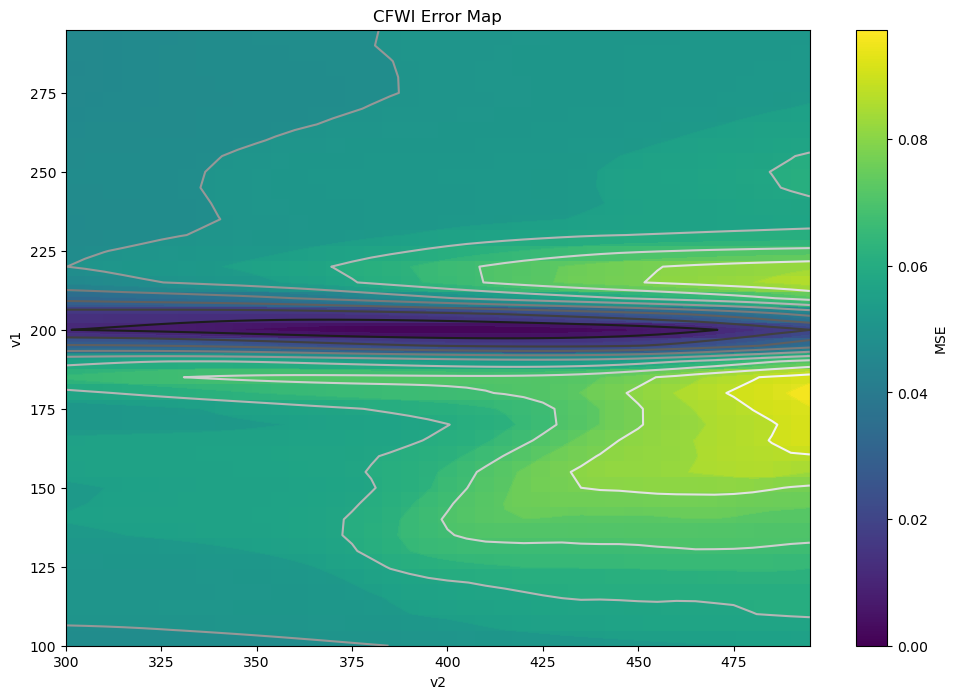

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

# 색상 매핑과 이미지
c = ax.imshow(error_map_c, extent=[v2_list[0], v2_list[-1], v1_list[0], v1_list[-1]],
              aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(c, label='MSE')

# 등고선 채우기
filled_contour = ax.contourf(v2_list, v1_list, error_map_c, levels=20, cmap='viridis', alpha=0.6)

# 등고선 추가 (Greys 색상맵 사용)
contour = ax.contour(v2_list, v1_list, error_map_c, levels=10, cmap='Greys_r', linewidths=1.5)

# 축 및 제목 설정
ax.set_xlabel('v2')
ax.set_ylabel('v1')
ax.set_title('CFWI Error Map')

plt.show()

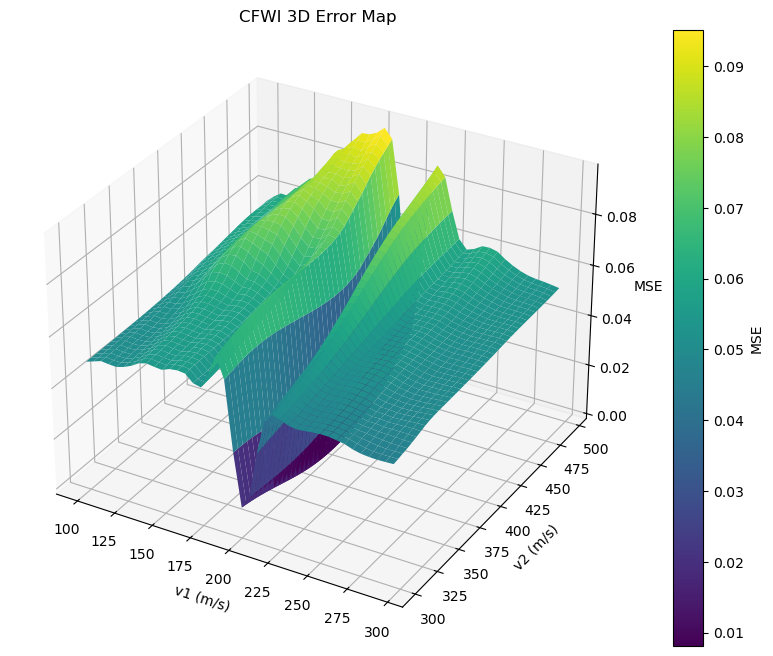

In [23]:
V1, V2 = np.meshgrid(v1_list, v2_list, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface Plot 생성
surf = ax.plot_surface(V1, V2, error_map_c, cmap='viridis', edgecolor='none')
ax.set_xlabel('v1 (m/s)')
ax.set_ylabel('v2 (m/s)')
ax.set_zlabel('MSE')
ax.set_title('CFWI 3D Error Map')
fig.colorbar(surf, ax=ax, label='MSE')
plt.show()

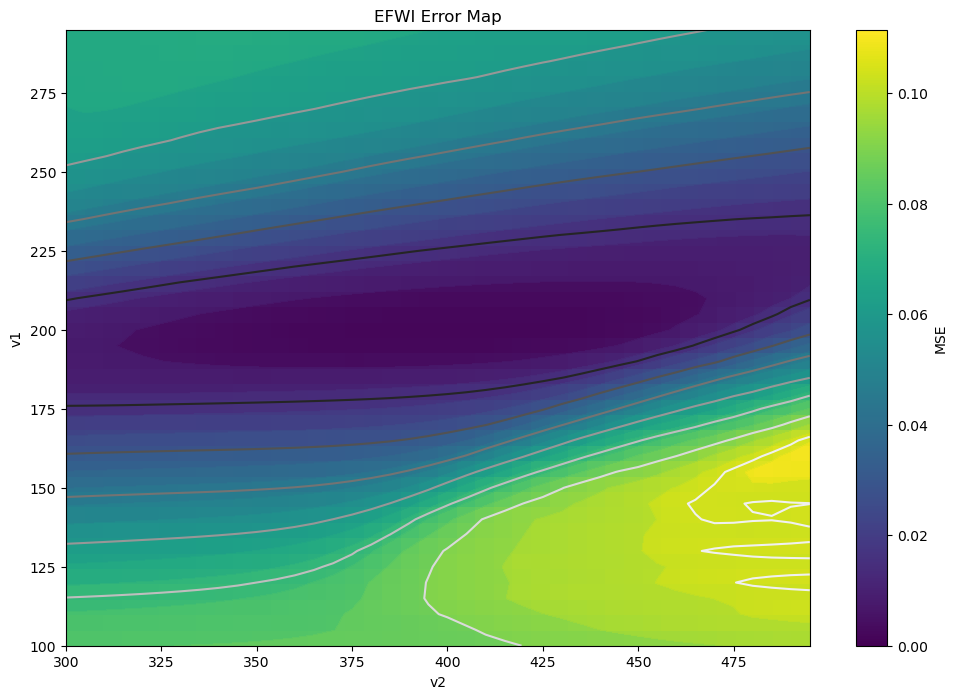

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

# 색상 매핑과 이미지
c = ax.imshow(error_map_e, extent=[v2_list[0], v2_list[-1], v1_list[0], v1_list[-1]],
              aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(c, label='MSE')

# 등고선 채우기
filled_contour = ax.contourf(v2_list, v1_list, error_map_e, levels=20, cmap='viridis', alpha=0.6)

# 등고선 추가 (Greys 색상맵 사용)
contour = ax.contour(v2_list, v1_list, error_map_e, levels=10, cmap='Greys_r', linewidths=1.5)

# 축 및 제목 설정
ax.set_xlabel('v2')
ax.set_ylabel('v1')
ax.set_title('EFWI Error Map')

plt.show()

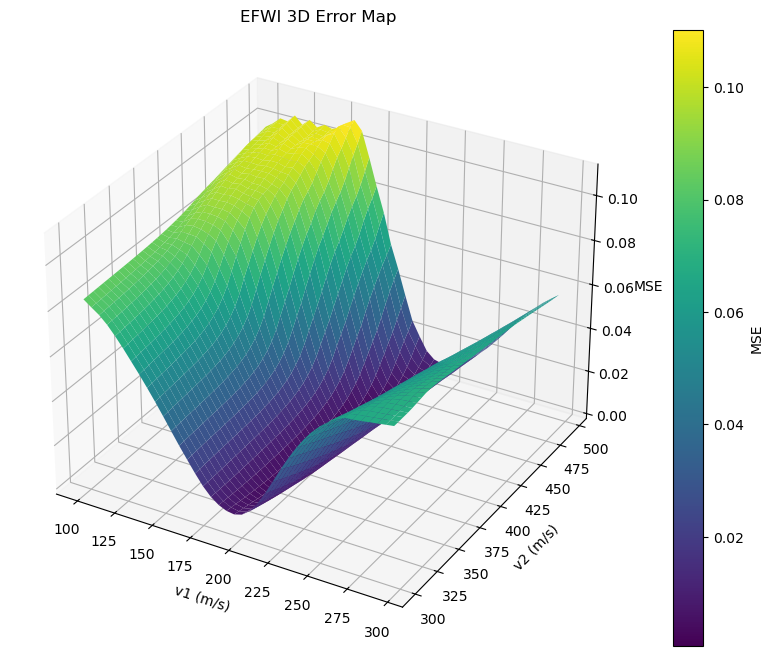

In [25]:
V1, V2 = np.meshgrid(v1_list, v2_list, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface Plot 생성
surf = ax.plot_surface(V1, V2, error_map_e, cmap='viridis', edgecolor='none')
ax.set_xlabel('v1 (m/s)')
ax.set_ylabel('v2 (m/s)')
ax.set_zlabel('MSE')
ax.set_title('EFWI 3D Error Map')
fig.colorbar(surf, ax=ax, label='MSE')
# SVG 파일로 저장
plt.show()